<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/npr-working/isoscape_evals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational model

Find the mean/variance of O18 ratios (as well as N15 and C13 in the future) at a particular lat/lon across Brazil.

# Import libraries required

In [1]:
import importlib
from datetime import datetime
import sys
import os

In [2]:
!if [ ! -d "/content/ddf_common_stub" ] ; then git clone -b test https://github.com/tnc-br/ddf_common_stub.git; fi
sys.path.append("/content/ddf_common_stub/")
import ddfimport
ddfimport.ddf_import_common()

Cloning into 'ddf_common_stub'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 18 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 7.36 KiB | 2.45 MiB/s, done.
Resolving deltas: 100% (7/7), done.
executing checkout_branch ...
b''
main branch checked out as readonly. You may now use ddf_common imports


In [3]:
import train_variational_inference_model as tvim
import raster
import eeddf

# Leave test_environment=True. Experiments must be done in test.
eeddf.initialize_ddf(test_environment=True)

# Data configuration

In [19]:
from google.colab import drive
drive.mount(raster.GDRIVE_BASE)

# REQUIREMENTS:

# 1) Column names must match features_to_standardize, features_to_passthrough
# 2) Label columns in particular must match var_label and mean_label.
#
# If you used the data ingestion notebook (ingestion.ipynb) then this
# should be set up for you already.

# TRAINING FILE PARAMS
DATABASE_DIR = raster.GDRIVE_BASE + raster.SAMPLE_DATA_BASE
TRAINING_SET_FILE = 'demo_train_fixed_grouped.csv' #@param
VALIDATION_SET_FILE = 'demo_validation_fixed_grouped.csv' #@param
TEST_SET_FILE = 'demo_test_fixed_grouped.csv' #@param

# EVAL FILE PARAMS
EVAL_DATASET = 'demo_test_fixed_grouped.csv' #@param
ORIGINAL_DATASET = '2023_06_23_Results_Google.csv' #@param

fileset = {
    'TRAIN' : os.path.join(DATABASE_DIR, TRAINING_SET_FILE),
    'TEST' : os.path.join(DATABASE_DIR, VALIDATION_SET_FILE),
    'VALIDATION' : os.path.join(DATABASE_DIR, TEST_SET_FILE),
    'EVAL' : os.path.join(DATABASE_DIR, EVAL_DATASET),
    'ORIGINAL' : os.path.join(DATABASE_DIR, ORIGINAL_DATASET)
}

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Non-VI Models

In [16]:
import dataset

## Ordinary Kriging

In [20]:
params = tvim.VIModelTrainingParams(
    training_id = "test-okrige-2024-10-25-1", #@param
    num_epochs = -1,
    num_layers = -1,
    num_nodes_per_layer = -1,
    training_batch_size = -1,
    learning_rate = -1,
    mean_label = "d18O_cel_mean", #@param
    var_label = "d18O_cel_variance", #@param
    early_stopping_patience = -1,
    double_sided_kl = False,
    kl_num_samples_from_pred_dist = 1,
    dropout_rate = -1,
    activation_func = "",
    features_to_standardize = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION', 'brisoscape_mean_ISORIX', 'd13C_cel_mean', 'd13C_cel_var', 'ordinary_kriging_linear_d18O_predicted_mean', 'ordinary_kriging_linear_d18O_predicted_variance'], #@param
    features_to_passthrough = [], #@param
    resolution_x = 1024, #@param
    resolution_y = 1024, #@param
    tags = ["author:npr", "ordinary_kriging"], #@param
)
eval_params = tvim.VIModelEvalParams(
    samples_per_location = 5, #@param
    precision_target = 0.95, #@param
    recall_target = 0.95, #@param
    start_max_fraud_radius= 6, #@param
    end_max_fraud_radius = 3000, #@param
    radius_pace = 100, #@param
    trusted_buffer_radius = 5, #@param
    elements_to_eval = ['d18O_cel'], #@param
)


MODEL_SAVE_LOCATION = os.path.join(raster.GDRIVE_BASE, raster.MODEL_BASE, params.training_id + ".keras")
ISOSCAPE_SAVE_LOCATION = raster.get_raster_path(params.training_id+".tiff")


In [17]:
dataset

<module 'dataset' from '/tmp/ddf_common/dataset.py'>

In [ ]:
# https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/00_ordinary.html

## Regression Kriging

In [ ]:
# https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/generated/pykrige.rk.RegressionKriging.html#pykrige.rk.RegressionKriging

## MCMC?

In [ ]:
# https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98

# Model configuration

In [ ]:
# Convenience links:
# Paper: https://braintex.goog/project/6509cbf324c22900a893d018
# Experiment list: https://docs.google.com/spreadsheets/d/1QUGvdUkkYCnflTytaYelMsbzGjhvR0U_HBkRdDUdeGM/edit?gid=1787854098#gid=1787854098
#

In [8]:
params = tvim.VIModelTrainingParams(
    training_id = "test-2024-10-25", #@param
    num_epochs = 5000, #@param
    num_layers = 2, #@param
    num_nodes_per_layer = 20, #@param
    training_batch_size = 5, #@param
    learning_rate = 0.0001, #@param
    mean_label = "d18O_cel_mean", #@param
    var_label = "d18O_cel_variance", #@param
    early_stopping_patience = 100, #@param
    double_sided_kl = False, #@param
    kl_num_samples_from_pred_dist = 15, #@param
    dropout_rate = 0, #@param
    activation_func = "relu", #@param
    features_to_standardize = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION', 'brisoscape_mean_ISORIX', 'd13C_cel_mean', 'd13C_cel_var', 'ordinary_kriging_linear_d18O_predicted_mean', 'ordinary_kriging_linear_d18O_predicted_variance'], #@param
    features_to_passthrough = [], #@param
    resolution_x = 1024, #@param
    resolution_y = 1024, #@param
    tags = ["author:npr", "ViNN"], #@param
    foo = "bar"
)



In [9]:
eval_params = tvim.VIModelEvalParams(
    samples_per_location = 5, #@param
    precision_target = 0.95, #@param
    recall_target = 0.95, #@param
    start_max_fraud_radius= 6, #@param
    end_max_fraud_radius = 3000, #@param
    radius_pace = 100, #@param
    trusted_buffer_radius = 5, #@param
    elements_to_eval = ['d18O_cel'], #@param
)

# Train the model

Driver: GTiff/GeoTIFF
Size is 541 x 467 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-73.922043, 5.233124)
Pixel Size = (0.08333, -0.08333)
Driver: GTiff/GeoTIFF
Size is 235 x 218 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0, 4.5)
Pixel Size = (0.16666668085106384, -0.1666666513761468)
Driver: GTiff/GeoTIFF
Size is 235 x 218 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTH

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 16)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 20)             │            340 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 20)             │            420 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ var_output (Dense)        │ (None, 1)              │             21 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mean_output (Dense)       │ (None, 1)              │             21 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 1)              │              0 │ var_output[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 1)              │              0 │ mean_output[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 1)              │              0 │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1)              │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ softplus_layer            │ (None, 1)              │              0 │ add_1[0][0]            │
│ (SoftplusLayer)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2)              │              0 │ add[0][0],             │
│                           │                        │                │ softplus_layer[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 802 (3.13 KB)

 Trainable params: 802 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 460: early stopping
Restoring model weights from the end of the best epoch: 360.


/tmp/ddf_common/model.py:233: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


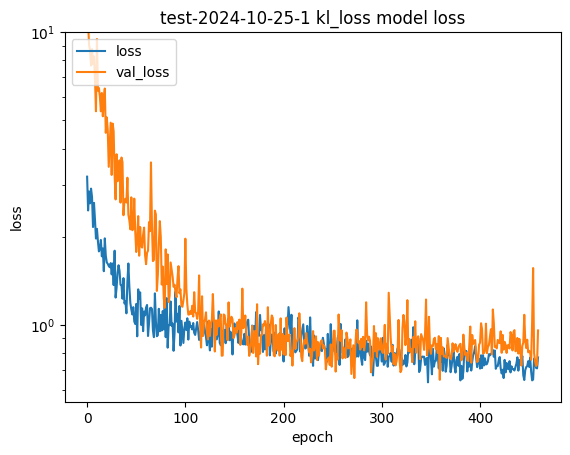

Val loss: 0.6480587124824524
Train loss: 0.8041459918022156
Test loss: 1.117887258529663
dO18 RMSE: 1.2302832411727829
Driver: GTiff/GeoTIFF
Size is 941 x 937 x 12
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.04166666666665718, -0.04166666666667143)
Driver: GTiff/GeoTIFF
Size is 941 x 937 x 12
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel 

100%|██████████| 1024/1024 [02:02<00:00,  8.34it/s]


Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)
Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)


Streaming output truncated to the last 5000 lines.
/tmp/ddf_common/hypothesis.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  isotope_variance = isotope_variances[i]
/tmp/ddf_common/hypothesis.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_sample_size = isotope_counts[i]
/tmp/ddf_common/hypothesis.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  isotope_variance = isotope_variances[i]
/tmp/ddf_common/hypothesis.p

In [11]:
EVAL_ONLY = False #@param{type:'boolean'}
res = tvim.train_variational_inference_model(params, eval_params, fileset, ISOSCAPE_SAVE_LOCATION, MODEL_SAVE_LOCATION, eval_only=EVAL_ONLY)

# Optional Rendering

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')

means_isoscape = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=0)
raster.animate(means_isoscape,  1, 1)

In [ ]:
vars_isoscape = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=1)
raster.animate(vars_isoscape,  1, 1)